# Benchmark Model Predicted Results vs Experiments

04/30/2023

Andrew Weng

In [39]:
import os, sys

# Move the path up a level to be able to index into source files
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

from src import cellsim as cellsim 

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from src import plotter as plotter

%matplotlib widget
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the Experimental Data

In [40]:
plotter.initialize(plt)
target_dir = os.getcwd()
target_dir_arbin = f'{target_dir}/data/raw/from-voltaiq'
file_indices_to_include = np.array([1])

cellid = 152071

# Configure Filenames 
file_arbin_list = [
f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMBASE_1_P45C_5P0PSI_20220902_R1.csv',
f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
                    ]

daq_channel = 'Key_CH0'

hr_max = 65

# Load the Arbin Data
df_arbin_list = []

for file in np.array(file_arbin_list)[file_indices_to_include]:

    df = pd.read_csv(file)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Timestamp']= df['Timestamp'].apply(lambda x : x.tz_localize(None))
    df_arbin_list.append(df)

df_arbin = pd.concat(df_arbin_list, axis=0)

# Load the Keyence data
file_keyence = f'{target_dir}/data/raw/from-keyence/keyence_20220901_213928.csv'
df_keyence = pd.read_csv(file_keyence)
df_keyence['computer time'] = pd.to_datetime(df_keyence['computer time'], unit='s')
df_keyence['computer time'] = df_keyence['computer time'].apply(lambda x : x.tz_localize(None))

# Filter the Keyence data
df_keyence = df_keyence.loc[(df_keyence['computer time'] > df_arbin['Timestamp'].iloc[0]) & \
                            (df_keyence['computer time'] < df_arbin['Timestamp'].iloc[-1])]
y_strain = df_keyence[daq_channel] - df_keyence[daq_channel].iloc[0]
y_strain[y_strain > 500] = np.NaN

/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_76770/3793840652.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_voltage.iloc[np.where(tv/3600 > hr_max)] = np.NaN


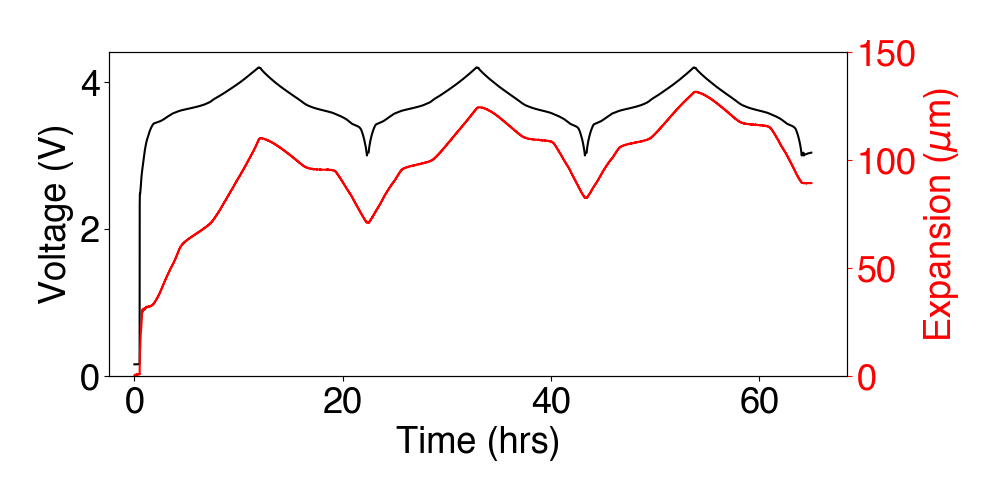

In [41]:
plt.figure(figsize=(10,5))

# The voltage plot
ax1 = plt.subplot()

tv = df_arbin['Timestamp'].astype(int)
tv = (tv - np.min(tv)) / 1e9
y_voltage = df_arbin['Potential (V)']

y_voltage.iloc[np.where(tv/3600 > hr_max)] = np.NaN

ax1.plot(tv/3600, y_voltage, color='k')
ax1.set_xlabel('Time (hrs)')
ax1.set_ylabel('Voltage (V)')
ax1.set_ylim(bottom=0)
ax1.grid(False)
ax1.set_xlim((-0.1 * 24, 2.85 * 24))

# The expansion plot
ax2 = ax1.twinx()

tt = df_keyence['computer time'].astype(int)
tt = (tt - np.min(tt)) / 1e9

y_strain.iloc[np.where(tt/3600 > hr_max)] = np.NaN

ax2.plot(tt/3600, y_strain, color='r')
ax2.set_ylabel(r'Expansion ($\mu$m)')
ax2.tick_params(axis='y', colors='r')
ax2.yaxis.label.set_color('red')
ax2.set_ylim(bottom=0, top=150)
ax2.grid(False)

plt.savefig(f'outputs/figures/fig_strain_vs_voltage_cell{cellid}.png', dpi=300)

In [42]:
%autoreload

Q0 = 2.35 # Ah
Ichg = Q0/10
Idch = -Q0/10
Icv = Q0/20

vmax = 4.2
vmin = 3.0

cell = cellsim.Cell()
cell.load_config('params/default.yaml')
sim = cellsim.Simulation(cell, 100*3600)

sim.run_rest(1, rest_time_hrs=0.5)
sim.run_chg_cccv(2, Ichg, Icv, vmax)
sim.run_dch_cccv(2, Idch, Idch, vmin)
sim.run_chg_cccv(3, Ichg, Icv, vmax)
sim.run_dch_cccv(3, Idch, Idch, vmin)
sim.run_chg_cccv(4, Ichg, Icv, vmax)
sim.run_dch_cccv(4, Idch, Idch, vmin)
sim.run_rest(5, rest_time_hrs=1)

df = sim.get_results()

Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...
Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc5: Rest for 1 hours...


In [43]:
df.columns

Index(['name', 'cell', 'dt', 't', 'curr_k', 'i_app', 'cycle_number',
       'step_number', 'theta_n', 'theta_p', 'ocv_n', 'ocv_p', 'eta_n', 'eta_p',
       'ocv', 'vt', 'i_int', 'i_r1p', 'i_r1n', 'j_sei', 'i_sei', 'q_sei',
       'D_sei1', 'D_sei2', 'V_sei', 'j_sei1', 'j_sei2', 'i_sei1', 'i_sei2',
       'q_sei1', 'q_sei2', 'j_sei_rxn1', 'j_sei_rxn2', 'j_sei_dif1',
       'j_sei_dif2', 'eta_sei1', 'eta_sei2', 'delta_sei', 'delta_sei1',
       'delta_sei2', 'delta_n', 'delta_p', 'expansion_rev', 'expansion_irrev'],
      dtype='object')

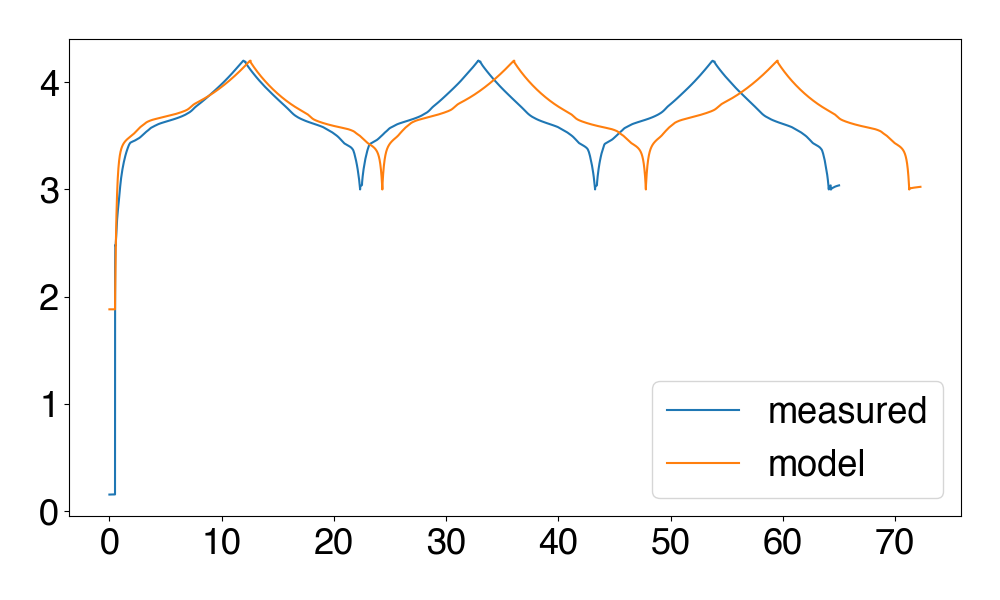

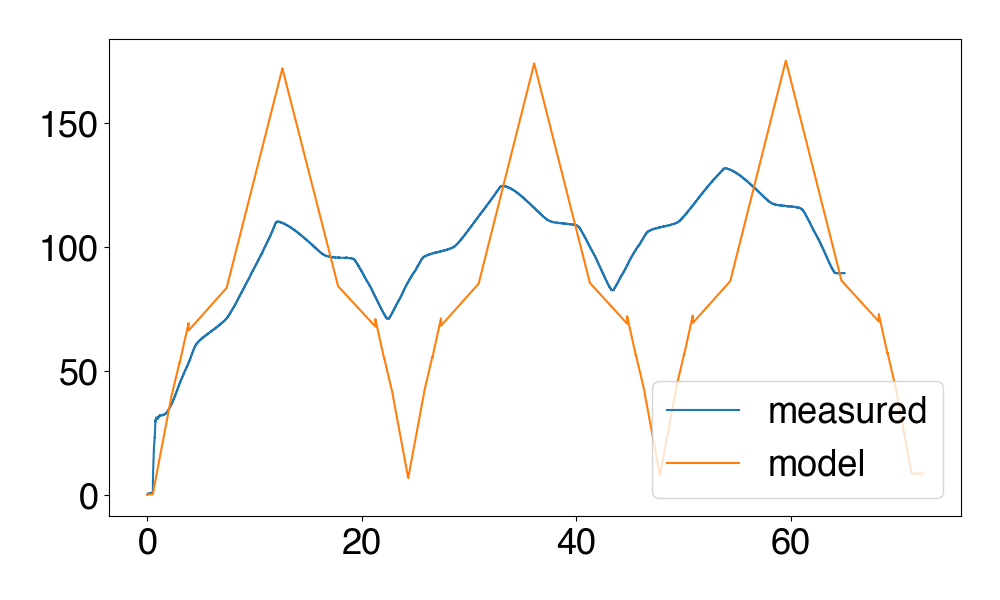

In [44]:
plt.figure(figsize=(10,6))
plt.grid(False)

plt.plot(tv/3600, y_voltage, label='measured')
plt.plot(df['t']/3600, df['vt'], label='model')
plt.legend()


plt.figure(figsize=(10,6))
plt.grid(False)

plt.plot(tt/3600, y_strain, label='measured')
plt.plot(df['t']/3600, (df['expansion_rev'] + df['expansion_irrev'])*1e6, label='model')
plt.legend()

In [45]:
df = pd.DataFrame(sim.__dict__)
df

,name,cell,dt,t,curr_k,i_app,cycle_number,step_number,theta_n,theta_p,...,j_sei_dif2,eta_sei1,eta_sei2,delta_sei,delta_sei1,delta_sei2,delta_n,delta_p,expansion_rev,expansion_irrev
0,DefaultSim,<src.cellsim.Cell object at 0x1217f79d0>,1.0,0.0,260092,0.0,1.0,3.0,0.000000e+00,1.0,...,NaN,0.000000,0.000000,5.000000e-09,2.500000e-09,2.500000e-09,0.000000e+00,-0.0,0.000000e+00,0.000000e+00
1,DefaultSim,<src.cellsim.Cell object at 0x1217f79d0>,1.0,1.0,260092,0.0,1.0,3.0,0.000000e+00,1.0,...,0.008763,0.136495,0.636495,5.000000e-09,2.500000e-09,2.500000e-09,0.000000e+00,-0.0,0.000000e+00,7.500000e-08
2,DefaultSim,<src.cellsim.Cell object at 0x1217f79d0>,1.0,2.0,260092,0.0,1.0,3.0,0.000000e+00,1.0,...,0.017526,0.136495,0.636495,5.000000e-09,2.500000e-09,2.500000e-09,0.000000e+00,-0.0,0.000000e+00,7.500000e-08
3,DefaultSim,<src.cellsim.Cell object at 0x1217f79d0>,1.0,3.0,260092,0.0,1.0,3.0,-2.421258e-12,1.0,...,0.017526,0.136495,0.636495,5.000000e-09,2.500000e-09,2.500000e-09,-4.842515e-13,-0.0,-8.070875e-16,7.500000e-08
4,DefaultSim,<src.cellsim.Cell object at 0x1217f79d0>,1.0,4.0,260092,0.0,1.0,3.0,-4.842519e-12,1.0,...,0.017526,0.136495,0.636495,5.000000e-09,2.500000e-09,2.500000e-09,-9.685038e-13,-0.0,-1.614176e-15,7.500000e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359995,DefaultSim,<src.cellsim.Cell object at 0x1217f79d0>,1.0,359995.0,260092,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
359996,DefaultSim,<src.cellsim.Cell object at 0x1217f79d0>,1.0,359996.0,260092,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
359997,DefaultSim,<src.cellsim.Cell object at 0x1217f79d0>,1.0,359997.0,260092,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
359998,DefaultSim,<src.cellsim.Cell object at 0x1217f79d0>,1.0,359998.0,260092,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Calculate cycle-by-cycle metrics

In [46]:
df = pd.DataFrame(sim.__dict__)
df['dq'] = np.abs(df['dt'] * df['i_app'] / 3600)
df_agg = df.groupby(['cycle_number', 'step_number'])['dq'].agg('sum')
df_agg

cycle_number  step_number
0.0           0.0            0.000000
1.0           3.0            0.000000
2.0           0.0            2.823982
              1.0            0.010571
              2.0            2.757464
3.0           0.0            2.746889
              1.0            0.010521
              2.0            2.754918
4.0           0.0            2.744343
              1.0            0.010529
              2.0            2.753808
5.0           3.0            0.000000
Name: dq, dtype: float64

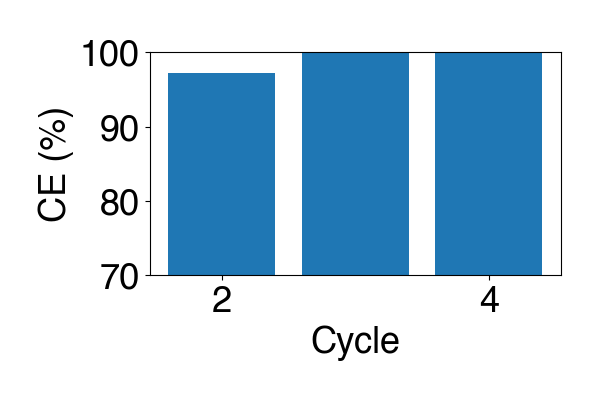

In [47]:
from matplotlib import pyplot as plt

ce = []
cycle_index = np.array([2, 3, 4])

for i in cycle_index:
    ce.append(df_agg[i][2] / (df_agg[i][0] + df_agg[i][1]))

ce = np.array(ce)

plt.figure(figsize=(6, 4))
plt.bar(cycle_index, ce*100)
plt.ylabel('CE (%)')
plt.grid(False)
plt.xlabel('Cycle')
plt.ylim([70, 100])
plt.show()


Text(0, 0.5, '$U_n$')

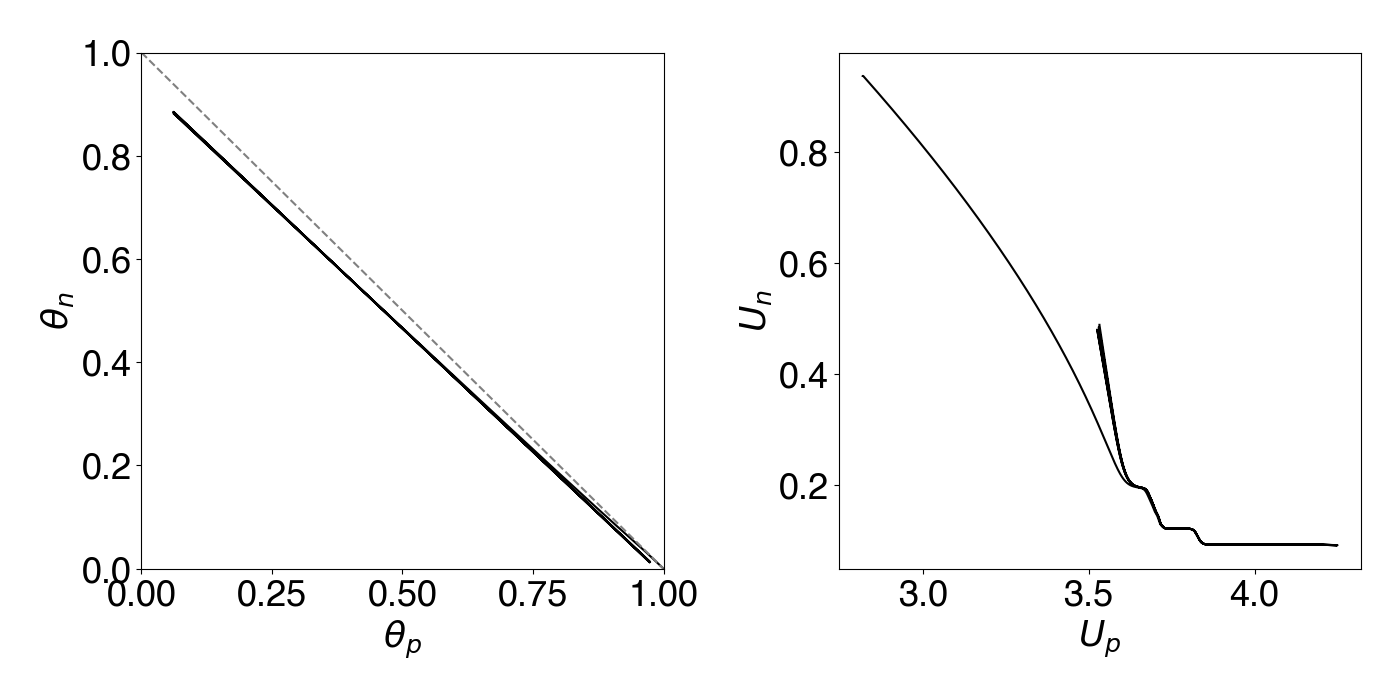

In [48]:
fh, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

xx = np.linspace(0, 1, 100)
ax0.plot(sim.theta_p, sim.theta_n, c='k')
ax0.plot(xx, 1-xx, c=(0.5,0.5,0.5), ls='--')
ax0.set_xlabel(r'$\theta_p$')
ax0.set_ylabel(r'$\theta_n$')
ax0.grid(False)
ax0.set_xlim((0,1))
ax0.set_ylim((0,1))

ax1.plot(sim.ocv_p, sim.ocv_n, c='k')
ax1.grid(False)
ax1.set_xlabel(r'$U_p$')
ax1.set_ylabel(r'$U_n$')